In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from category_encoders import TargetEncoder
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool

In [2]:
df = pd.read_csv('beer_reviews.csv')
df.head(2)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213


<class 'pandas.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  str    
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  str    
 7   beer_style          1586614 non-null  str    
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  str    
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), str(4)
memory usage: 157.4 MB
None
brewery_id                0
brewery_name             15
review_time 

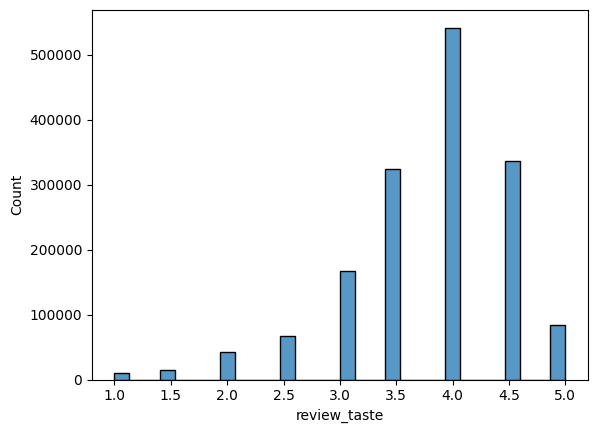

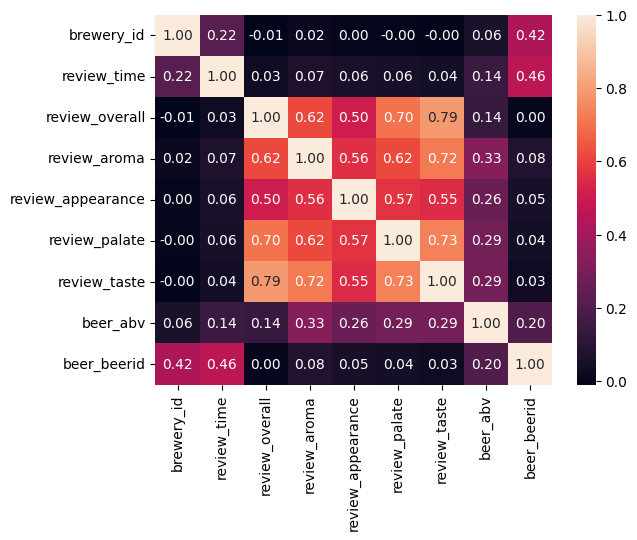

brewery_name 5742
review_profilename 33387
beer_style 104
beer_name 56857


In [3]:
print(df.info())
print(df.isna().sum())

# Распределение целевой переменной
sns.histplot(df['review_taste'], bins=30)
plt.show()

# Корреляции числовых колонок
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt=".2f")
plt.show()

# Уникальные категории в категориальных признаках
cat_cols = df.select_dtypes(exclude='number').columns.tolist()
for col in cat_cols:
    print(col, df[col].nunique())


In [4]:
X = df.drop('review_taste', axis=1)
y = df['review_taste']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [5]:
user_stats = X_train['review_profilename'].value_counts()
min_user_freq = np.log1p(user_stats.min())

style_avg_abv = X_train.groupby('beer_style')['beer_abv'].mean().to_dict()
brewery_avg_abv = X_train.groupby('brewery_name')['beer_abv'].median().to_dict()
brewery_median = np.median(list(brewery_avg_abv.values()))

In [6]:
def feature_engineer(df_input):
    df = df_input.copy()
    # user_review_freq
    df['user_review_freq'] = np.log1p(df['review_profilename'].map(user_stats))
    df['user_review_freq'] = df['user_review_freq'].fillna(min_user_freq)
    # brewery_avg_abv
    df['brewery_avg_abv'] = df['brewery_name'].map(brewery_avg_abv).fillna(brewery_median)
    
    # beer_abv
    df['beer_abv'] = df['beer_abv'].fillna(df['beer_style'].map(style_avg_abv).fillna(df['beer_abv'].median()))
    # удаляем ненужные колонки
    df = df.drop(['brewery_name','brewery_id','review_profilename','beer_style','beer_name'], axis=1)
    return df

X_train_fe = feature_engineer(X_train)
X_test_fe = feature_engineer(X_test)

In [7]:
num_cols = X_train_fe.select_dtypes(include='number').columns.tolist()
cat_cols = X_train_fe.select_dtypes(exclude='number').columns.tolist()

**BAGGING**

In [8]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

bag_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=10, random_state=42),
    n_estimators=10,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', bag_model)
])

pipeline.fit(X_train_fe, y_train)

train_preds = pipeline.predict(X_train_fe)
test_preds = pipeline.predict(X_test_fe)
print("BaggingRegressor Train MAE:", mean_absolute_error(y_train, train_preds))
print("BaggingRegressor Test MAE:", mean_absolute_error(y_test, test_preds))


BaggingRegressor Train MAE: 0.27566165892105216
BaggingRegressor Test MAE: 0.2772189092884443


**CatBoostRegressor**

In [9]:
cat_features_cb = X_train_fe.select_dtypes(include='object').columns.tolist()

train_pool = Pool(data=X_train_fe, label=y_train, cat_features=cat_features_cb)
test_pool = Pool(data=X_test_fe, label=y_test, cat_features=cat_features_cb)

model_cat = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MAE',
    random_seed=42,
    verbose=100
)

model_cat.fit(train_pool)
train_preds = model_cat.predict(train_pool)
test_preds = model_cat.predict(test_pool)

print("CatBoostRegressor Train MAE:", mean_absolute_error(y_train, train_preds))
print("CatBoostRegressor Test MAE:", mean_absolute_error(y_test, test_preds))

0:	learn: 0.4983808	total: 282ms	remaining: 2m 20s
100:	learn: 0.2669986	total: 10.5s	remaining: 41.4s
200:	learn: 0.2622429	total: 21.3s	remaining: 31.7s
300:	learn: 0.2602663	total: 32s	remaining: 21.1s
400:	learn: 0.2590810	total: 44.4s	remaining: 11s
499:	learn: 0.2584148	total: 56.6s	remaining: 0us
CatBoostRegressor Train MAE: 0.2584157712128117
CatBoostRegressor Test MAE: 0.25886013320089535


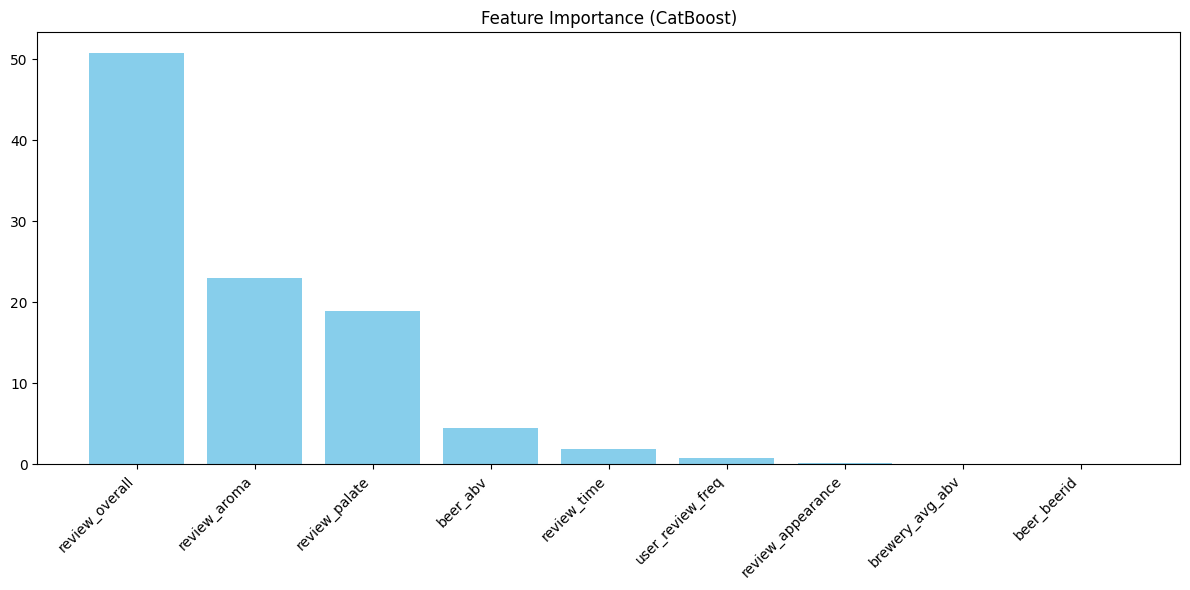

In [10]:
#Важность признаков CatBoost

feature_importances = model_cat.get_feature_importance(train_pool)
feature_names = X_train_fe.columns

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importance (CatBoost)")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='skyblue')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()
